<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries" data-toc-modified-id="Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Reading-the-data-files" data-toc-modified-id="Reading-the-data-files-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reading the data files</a></span><ul class="toc-item"><li><span><a href="#Overview-from-the-data" data-toc-modified-id="Overview-from-the-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Overview from the data</a></span></li></ul></li><li><span><a href="#Graphical-Exploration" data-toc-modified-id="Graphical-Exploration-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Graphical Exploration</a></span><ul class="toc-item"><li><span><a href="#E-Commerce-Orders-in-Brazil" data-toc-modified-id="E-Commerce-Orders-in-Brazil-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>E-Commerce Orders in Brazil</a></span></li></ul></li></ul></div>

The objective of this notebook is to propose an analytical view of e-commerce relationship in Brazil. For this we will first go trough an exploratory data analysis using graphical tools to create self explanatory plots for better understanding what is behind braziian online purchasing. Finally we will look at customers reviews and implement **_Sentimental Analysis_** to make a text classification using **_Natural Language Process_** tools.

Let's get to work!

# Libraries

In [1]:
# Standard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec

# Utilities
from utils.viz_utils import *
from utils.ml_utils import *
from utils.custom_transformers import *

# Reading the data files

For this task we have differente data sources, each one describing a specific topic related to e-commerce sales. The files are:

    olist_customers_dataset.csv
    olist_geolocation_dataset.csv
    olist_orders_dataset.csv
    olist_order_items_dataset.csv
    olist_order_payments_dataset.csv
    olist_order_reviews_dataset.csv
    olist_products_dataset.csv
    olist_sellers_dataset.csv
    product_category_name_translation.csv
    
The relationship between these files are described below:

<img src="../old_notebooks/images/brazilian_e-commerce_schema.png" alt="Dataset Schema" style="width: 750px;"/>

So, let's first read the datasets and purpose a join between them to make our Exploration Data Analysis easier and more understandable. This step would prevent changing between DataFrames for different analysis.

In [2]:
# Reading all the files
raw_path = '../bases/'
olist_customer = pd.read_csv(raw_path + 'olist_customers_dataset.csv')
olist_geolocation = pd.read_csv(raw_path + 'olist_geolocation_dataset.csv')
olist_orders = pd.read_csv(raw_path + 'olist_orders_dataset.csv')
olist_order_items = pd.read_csv(raw_path + 'olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv(raw_path + 'olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv(raw_path + 'olist_order_reviews_dataset.csv')
olist_products = pd.read_csv(raw_path + 'olist_products_dataset.csv')
olist_sellers = pd.read_csv(raw_path + 'olist_sellers_dataset.csv')

## Overview from the data

Before creating a unique dataset with all useful information, let's look at the shape of each dataset, so we can be more assertive on how to use joining statements. 

In [3]:
# Collections for each dataset
datasets = [olist_customer, olist_geolocation, olist_orders, olist_order_items, olist_order_payments,
            olist_order_reviews, olist_products, olist_sellers]
names = ['olist_customer', 'olist_geolocation', 'olist_orders', 'olist_order_items', 'olist_order_payments',
         'olist_order_reviews', 'olist_products', 'olist_sellers']

# Creating a DataFrame with useful information about all datasets
data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

data_info.style.background_gradient()

,dataset,n_rows,n_cols,null_amount,qty_null_columns,null_columns
0,olist_customer,99441,5,0,0,
1,olist_geolocation,1000163,5,0,0,
2,olist_orders,99441,8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
3,olist_order_items,112650,7,0,0,
4,olist_order_payments,103886,5,0,0,
5,olist_order_reviews,100000,7,146532,2,"review_comment_title, review_comment_message"
6,olist_products,32951,9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,olist_sellers,3095,4,0,0,


Now let's use a homemade function found on the module `viz_utils.py` for looking at each dataset and bring some detailed parameters about the data content. With this function we can get the following information for each dataset column:

    - Column name;
    - Null amount;
    - Null percentage among the respective dataset;
    - Data type;
    - total categorical entries;

In [4]:
df_overview = pd.DataFrame({})
name_col = []
for name, df in zip(names, datasets):
    name_col += [name] * df.shape[1]
    df_overview = df_overview.append(data_overview(df))
    df_overview['dataset_name'] = name_col

df_overview = df_overview.loc[:, ['dataset_name', 'feature', 'qtd_null', 'percent_null', 'dtype', 'qtd_cat']]
df_overview

,dataset_name,feature,qtd_null,percent_null,dtype,qtd_cat
0,olist_customer,customer_id,0,0.000000,object,99441
1,olist_customer,customer_unique_id,0,0.000000,object,96096
2,olist_customer,customer_zip_code_prefix,0,0.000000,int64,0
3,olist_customer,customer_city,0,0.000000,object,4119
4,olist_customer,customer_state,0,0.000000,object,27
0,olist_geolocation,geolocation_zip_code_prefix,0,0.000000,int64,0
1,olist_geolocation,geolocation_lat,0,0.000000,float64,0
2,olist_geolocation,geolocation_lng,0,0.000000,float64,0
3,olist_geolocation,geolocation_city,0,0.000000,object,8011
4,olist_geolocation,geolocation_state,0,0.000000,object,27


Well, we can now use the DataFrame above wherever we want to do dome data transformation or data analysis. It contains basically the main information about each column for each one of the datasets available. This is very useful!

# Graphical Exploration

So now we will go trough an exploratory data analysis to get insights from E-Commerce in Brazil. The aim here is to divide this session into topics so we can explore graphics for each subject (orders, customers, products, items, and others).

## E-Commerce Orders in Brazil

We know that e-commerce is really a growing trend in a global perspective. Let's dive into the orders dataset to see how this trend can be presented in Brazil, at least on the dataset range.

Looking at the dataset columns, we can see orders with different `status` and with different timestamp columns like `purchase`, `approved`, `delivered` and `estimated delivery`. First, let's look at the status of the orders we have in this dataset.

___
* _How many orders we have for each status?_
___

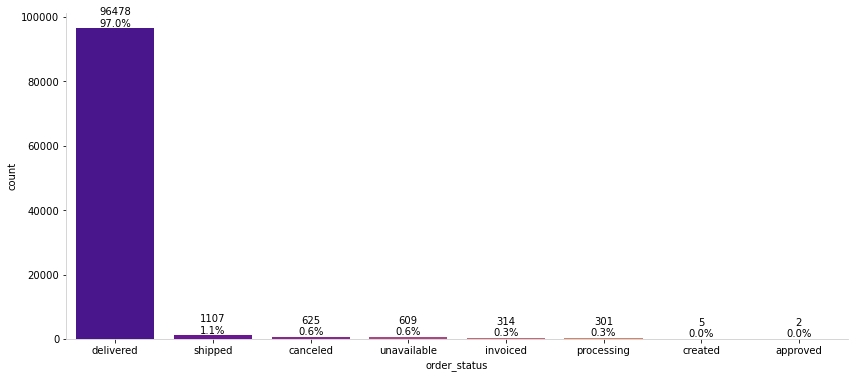

In [5]:
df_orders = olist_orders.merge(olist_customer, how='left', on='customer_id')
fig, ax = plt.subplots(figsize=(14, 6))
single_countplot(df_orders, col='order_status', ax=ax)
plt.show()

By the time this dataset was created, the highest amount of orders went from delivered ones. Only 3% of all orders came from the other status.

___
* _Is that a growing trend on e-commerce in Brazil? How can we describe a complete scenario?_
___

For the next plots, let's dive into the real evolution of e-commerce in terms of purchase orders. For this, we have to extract some info on the `order_purchase_timestamp` following the topics:

    1. Transform timestamp columns;
    2. Extract time attributes from these datetime columns (year, month, day, day of week and hour);
    3. Evaluate the e-commerce scenario using this attributes.

In [6]:
# Changing the data type for date columns
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                  'order_estimated_delivery_date']
for col in timestamp_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])
    
# Extracting attributes for purchase date - Year and Month
df_orders['order_purchase_year'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.year)
df_orders['order_purchase_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.month)
df_orders['order_purchase_month_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
df_orders['order_purchase_year_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))

# Extracting attributes for purchase date - Day and Day of Week
df_orders['order_purchase_day'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.day)
df_orders['order_purchase_dayofweek'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df_orders['order_purchase_dayofweek_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

# Extracting attributes for purchase date - Hour and Time of the Day
df_orders['order_purchase_hour'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df_orders['order_purchase_time_day'] = pd.cut(df_orders['order_purchase_hour'], hours_bins, labels=hours_labels)

# New DataFrame after transformations
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,customer_state,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,SP,2017,10,Oct,201710,2,0,Mon,10,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,BA,2018,7,Jul,201807,24,1,Tue,20,Night
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,GO,2018,8,Aug,201808,8,2,Wed,8,Morning
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,RN,2017,11,Nov,201711,18,5,Sat,19,Night
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,SP,2018,2,Feb,201802,13,1,Tue,21,Night


So now we can purpose a complete analysis on orders amount of brazilian e-commerce during the period of the dataset. For that let's plot three graphs using a `GridSpec` with the aim answear the following questions:

    1. Is there any growing trend on brazilian e-commerce?
    2. On what day of week brazilians customers tend to do online purchasing?
    3. What time brazilians customers tend do buy (Dawn, Morning, Afternoon or Night)?

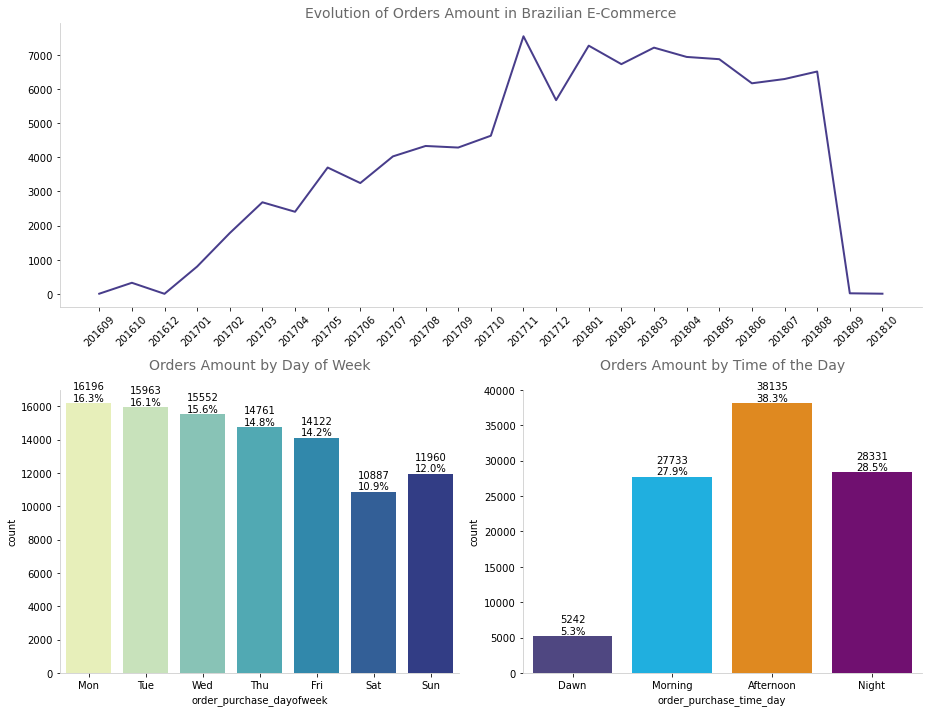

In [7]:
fig = plt.figure(constrained_layout=True, figsize=(13, 10))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Lineplot - Evolution of e-commerce orders along time 
sns.lineplot(data=df_orders['order_purchase_year_month'].value_counts().sort_index(), ax=ax1, 
             color='darkslateblue', linewidth=2)
format_spines(ax1, right_border=False)  
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_title('Evolution of Orders Amount in Brazilian E-Commerce', size=14, color='dimgrey')

# Barchart - Total of orders by day of week
single_countplot(df_orders, col='order_purchase_dayofweek', ax=ax2, order=False, palette='YlGnBu')
weekday_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax2.set_xticklabels(weekday_label)
ax2.set_title('Orders Amount by Day of Week', size=14, color='dimgrey', pad=20)

# Barchart - Total of orders by time of the day
day_color_list = ['darkslateblue', 'deepskyblue', 'darkorange', 'purple']
single_countplot(df_orders, col='order_purchase_time_day', ax=ax3, order=False, palette=day_color_list)
ax3.set_title('Orders Amount by Time of the Day', size=14, color='dimgrey', pad=20)

plt.tight_layout()
plt.show()

By the chart above we can conclude:

* E-commerce on Brazil really has a growing trend along the time. We can see some seasonality with peaks at specific months, but in general we can see clear that customers are more prone to buy things online than before.
* Monday are the prefered day for brazilian's customers and they tend to buy more at afternoons.

_Obs: we have a sharp decrease between August 2018 and September 2018 and maybe the origin of that is related to noise on data. For further comparison between 2017 and 2018, let's just consider orders between January and August in both years_

___
* _E-commerce: a comparison between 2017 and 2018_
___

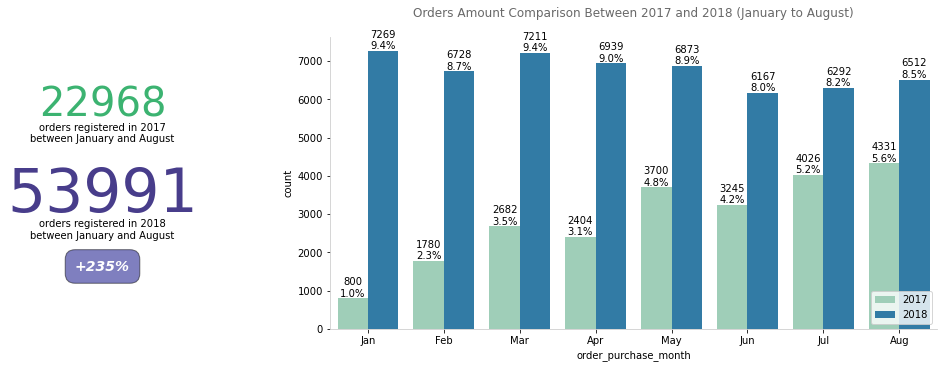

In [8]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(13, 5))

# Axis definition
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])

# Annotation - Grown on e-commerce orders between 2017 and 2018
df_orders_compare = df_orders.query('order_purchase_year in (2017, 2018) & order_purchase_month <= 8')
year_orders = df_orders_compare['order_purchase_year'].value_counts()
growth = int(round(100 * year_orders[2018] / year_orders[2017], 0))
ax1.text(0.00, 0.73, f'{year_orders[2017]}', fontsize=40, color='mediumseagreen', ha='center')
ax1.text(0.00, 0.64, 'orders registered in 2017\nbetween January and August', fontsize=10, ha='center')
ax1.text(0.00, 0.40, f'{year_orders[2018]}', fontsize=60, color='darkslateblue', ha='center')
ax1.text(0.00, 0.31, 'orders registered in 2018\nbetween January and August', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax1.text(0.00, 0.20, f'{signal}{growth}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax1.axis('off')

# Bar chart - Comparison between monthly sales between 2017 and 2018
single_countplot(df_orders_compare, col='order_purchase_month', hue='order_purchase_year', ax=ax2, order=False,
                 palette='YlGnBu')
month_label = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
ax2.set_xticklabels(month_label)
ax2.set_title('Orders Amount Comparison Between 2017 and 2018 (January to August)', size=12, color='dimgrey', pad=20)
plt.legend(loc='lower right')
plt.show()

In this notebook we will also see in the future:

- E-commerce analysis by total of sales (in R$);
- Customers payment type;
- How do online sales are distributed on brazilian country?
- Delivery and freight value/time analysis;
- Natural Language Processing on online reviews;
- Sentimental analyis on online reviews.